In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import jax.numpy as jnp
import numpy as np

# PLOTTING
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.style.use('spiffy')
from spiffyplots import MultiPanel
from mycolorpy import colorlist as mcp
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Local imports
from src.core.activation import SoftReLu

In [7]:
colors_targets = ['#E09F1F', '#907245']
color_fits = ['#00C9B3', '#005B4E']

In [8]:
class ExcInhMicroCircuit:
        
    wXE: float = 1.0
    wXI: float = 0.0
    wIE: float = 1.0
    wEI: float = 1.0
    
    # Solver
    dt = 1/50               # 1/tau
    n_solver = 600          # number of solver steps
    
    alpha = 5.0
    
    def __init__(self, actE, actI) -> None:
        self.actE = actE
        self.actI = actI
            
    def vectorfield(self, state, t, x, target = None):    
        ue, ui = state
        
        due = -ue - self.wIE * self.actI(ui) + self.wXE * x
        dui = -ui + self.wEI * self.actE(ue) + self.wXI * x

        if target is not None:
            out = self.actE(ue)
            error = target - out
            dui -= self.alpha * error
            
        return np.array([due, dui])
            
    def solve_euler(self, x, target = None):
        
        # check if x is a scalar
        if np.isscalar(x):
            u = np.array([0, 0])            
        # otherwise x is a vector
        else:
            u = np.array([np.zeros(len(x)), np.zeros(len(x))])
        
        t = 0
        for i in range(self.n_solver):
            u = u + self.dt * self.vectorfield(u, t, x, target)
            t = t + self.dt  
            
        return u
    
    def traj_euler(self, x, target = None, u0 = None):
        
        # check if x is a scalar
        if np.isscalar(x):
            u = np.array([0, 0])            
        # otherwise x is a vector
        else:
            u = np.array([np.zeros(len(x)), np.zeros(len(x))])
        
        t = 0
        us = [u]
        ts = [t]
        
        for i in range(self.n_solver):
            u = u + self.dt * self.vectorfield(u, t, x, target)
            t = t + self.dt  
            us.append(u)
            ts.append(t)
            
        return np.array(ts), np.array(us)

    def dw_exact(self, x_range, target=None):
        
        state = self.solve_euler(x_range, target=target)
        ue, ui = state
        rE = self.actE(ue)
        rI = self.actI(ui)
        dw = x_range * (self.wEI * rE - self.actI.inv(rI)) * self.actE.deriv(ue)
        
        return state, dw
    
    def dw_inv_lin(self, x_range, theta, delta, target=None):
        
        state = self.solve_euler(x_range, target=target)
        ue, ui = state
        rE = self.actE(ue)
        rI = self.actI(ui)
        dw = x_range * (self.wEI * rE - lin_model(rI, theta, delta)) * self.actE.deriv(ue)
        
        return state, dw
    
def lin_model(y, theta, delta):
    return theta + delta * y
    

In [9]:
# LINEAR FITS
linear_params = ({'theta': 1.5,
                  'delta': 0.5},
                 {'theta': -0.5,
                  'delta': 1.5},
                 {'theta': 1.5,
                  'delta': 2.0},
                 {'theta': 4.0,
                  'delta': 1.0},
                 {'theta': 1.75,
                  'delta': 1.25},                 
                 )

# LINEAR FITS
linear_params = ({'theta': 1.0,
                  'delta': 0.5},
                 {'theta': 0,
                  'delta': 1.0},
                 {'theta': 0,
                  'delta': 1.5},
                 {'theta': 0,
                  'delta': 2.0},
                 {'theta': 0,
                  'delta': 3.0},                 
                 )

# Targets
target_1 = 4.0
target_2 = 3.0

params_act = {
    'scale': 1.0,
    'sharpness': 1.0,
    'shift': 3.0
}

preact = jnp.linspace(0, 28, 1000)
func = SoftReLu(**params_act)

model = ExcInhMicroCircuit(actE=func, actI=func)
model.wXE = np.array([1])

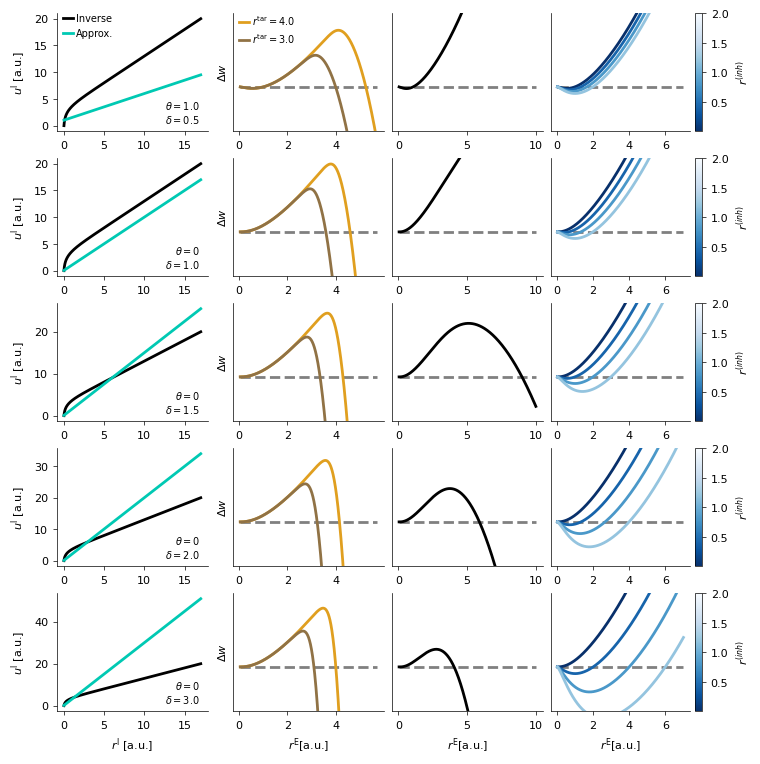

In [10]:
fig = MultiPanel(grid=[4, 4, 4, 4, 4], figsize=(7.0, 1.5 * 5))

ymin = -15
ymax = 25

# Iterate over different linear fits
for row_idx in range(5):
    
    preact = jnp.linspace(0, 20, 1000)
    pidx = np.arange(4) + row_idx * 4
    theta, delta = linear_params[row_idx]['theta'], linear_params[row_idx]['delta']

    # PANEL 1: Inverse function & linear approximation
    ax = fig.panels[pidx[0]]
    func = SoftReLu(**params_act)
    act = func(preact)
    deriv = func.deriv(preact)
    inv = func.inv(act)
    inv_lin = lin_model(act, theta, delta)

    ax.plot(act, inv, label='Inverse', lw=2, c='k')
    ax.plot(act, inv_lin, label='Approx.', lw=2, c=color_fits[0])

    if row_idx == 4:
        ax.set_xlabel(r'$r^{\mathrm{I}}$ [a.u.]')
    
    ax.set_ylabel(r'$u^{\mathrm{I}}$ [a.u.]')

    if row_idx == 0:
        ax.legend(loc='upper left', bbox_to_anchor=(0.0, 1.05), frameon=False,
                            fontsize=7, borderpad=0.1, handletextpad=0.3, handlelength=1.0)

    # Draw a little box in the bottom right corner that contains the parameters of the linear fit,
    # theta and delta
    ax.text(0.95, 0.05, r'$\theta = $' + '{}'.format(theta) + '\n' + r'$\delta = $' + '{}'.format(delta),
                        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)


    # PANEL 2: Feedback control
    ax = fig.panels[pidx[1]]

    state_1, dw_1 = model.dw_inv_lin(preact, theta, delta, target=target_1)
    state_2, dw_2 = model.dw_inv_lin(preact, theta, delta, target=target_2)

    # First target
    uE, uI = state_1
    rE = model.actE(uE)
    rI = model.actI(uI)
    ax.hlines(0, rE.min(), rE.max(), lw=2, linestyle='--', color='gray', zorder=0)
    ax.plot(rE, dw_1, label=r'$r^{\mathrm{tar}} = $' + '{}'.format(target_1), lw=2, c=colors_targets[0])

    # Second target
    uE, uI = state_2
    rE = model.actE(uE)
    rI = model.actI(uI)
    ax.plot(rE, dw_2, label=r'$r^{\mathrm{tar}} = $' + '{}'.format(target_2), lw=2, c=colors_targets[1])

    ax.set_yticks([])
    if row_idx == 4:
        ax.set_xlabel(r'$r^{\mathrm{E}}$'+ '[a.u.]')
        
    ax.set_ylabel(r'$\Delta w$')
    
    if row_idx == 0:
        ax.legend(fontsize=7, loc='upper left', bbox_to_anchor=(0.0, 1.05), 
                            frameon=False, borderpad=0.1, handletextpad=0.3, handlelength=1.0)
    
    ax.set_ylim(ymin, ymax)

    # PANEL 3: Microcircuit
    ax = fig.panels[pidx[2]]
    state, dw = model.dw_inv_lin(preact, theta, delta, target=None)

    uE, uI = state
    rE = model.actE(uE)
    rI = model.actI(uI)

    ax.plot(rE, dw, label='dw', lw=2, c='k')
    ax.hlines(0, rE.min(), rE.max(), lw=2, linestyle='--', color='gray', zorder=0)

    ax.set_yticks([])
    ax.set_ylim(ymin, ymax)
    
    if row_idx == 4:
        ax.set_xlabel(r'$r^{\mathrm{E}}$'+ '[a.u.]')

    # PANEL 4: Isolated Neuron
    ax= fig.panels[pidx[3]]
    preact = jnp.linspace(0, 10, 1000)

    # Isolated neuron plasticity (assuming w=1, x the only input and only externally provided inhibition)
    list_rI = np.linspace(0.01, 2, 4)
    colormap = mcp.gen_color(cmap='Blues_r', n=len(list_rI)+2)
    labels = list_rI

    uE = preact
    rE = model.actE(uE)

    for rI_idx, rI in enumerate(list_rI):
        dw = preact * model.actE.deriv(uE) * (rE - lin_model(rI, theta, delta))
        ax.plot (rE, dw, label=labels[rI_idx], color=colormap[rI_idx], lw=2)
    ax.hlines(0, rE.min(), rE.max(), lw=2, linestyle='--', color='gray', zorder=0)
        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    norm = mpl.colors.Normalize(vmin=list_rI.min(), vmax=list_rI.max())
    cbarMap = mpl.cm.ScalarMappable(cmap=mpl.cm.Blues_r, norm = norm)
    fig.fig.colorbar(cbarMap, cax=cax, orientation='vertical')
    cax.set_ylabel(r'$r^{(inh)}$')
    
    if row_idx == 4:
        ax.set_xlabel(r'$r^{\mathrm{E}}$' + '[a.u.]')
        
    #ax.set_ylabel(r'$\Delta w$')

    ax.set_yticks([])
    ax.set_ylim(ymin, ymax)

plt.show()
